# Base Functions

In [1]:
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
from skimage import io
# imports and stuff
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
import torchvision
from IPython.display import clear_output

from torch.autograd import Variable
#from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [2]:
# mount your google drive (follow the link, allow what is needed and get the authorization code)
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
FOLDER = 'gdrive/My Drive/'
sys.path.append(FOLDER)

WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
BATCH_SIZE = 2 # Number of samples in a mini-batch

LABELS = ["No vegetation", "buildings", "low veg.", "trees", "water", "Playground", "No change"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

MAIN_FOLDER = FOLDER + 'SECOND_Dataset/'
DATA_FOLDER1 = MAIN_FOLDER + 'im1/{}.png'
DATA_FOLDER2 = MAIN_FOLDER + 'im2/{}.png'
DATA_FOLDER = MAIN_FOLDER + 'DIFF/{}.png'
LABEL_FOLDER1 = MAIN_FOLDER + 'label1/{}.png'
LABEL_FOLDER2 = MAIN_FOLDER + 'label2/{}.png'

Mounted at /content/gdrive/


In [3]:
# Utils
# Let's define the  color palette
palette = {0 : (128, 128, 128), # No-veg / Impervious surfaces (Grey)
           1 : (128, 0, 0),     # Buildings (maroon)
           2 : (0, 128, 0),     # Low vegetation (Green)
           3 : (0, 255, 0),     # Trees (Lime)
           4 : (0, 0, 255),     # water (blue)
           5 : (255, 0, 0),     # Playground (red)
           6 : (255,255,255),   # No change
           7 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk
def metrics(predictions, gts, label_values=LABELS):
#def metrics(predictions, gts, label_values):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    #print("Confusion matrix :")
    #print(cm)
    
    #print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    #print("{} pixels processed".format(total))
    #print("Total accuracy : {}%".format(accuracy))
    
    #print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    #print("F1Score :")
    #for l_id, score in enumerate(F1Score):
        #print("{}: {}".format(label_values[l_id], score))

    #print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    #print("Kappa: " + str(kappa))
    return accuracy

In [4]:
from torchvision import models
 
def createDeepLabv3(outputchannels=7):
#def createDeepLabv3(outputchannels=1):

    
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Sigmoid activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [5]:
net=createDeepLabv3()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [6]:
""" The old code """
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    #test_labels = (np.asarray(io.imread(LABEL_FOLDER2.format(id)), dtype='uint8') for id in test_ids)
    test_labels = (convert_from_color(io.imread(LABEL_FOLDER2.format(id)))for id in test_ids)
    #eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt in tqdm(zip(test_images, test_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,2,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,2,2)
                    plt.imshow(convert_to_color(_pred))
                    plt.show()

                    clear_output()
                   
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)['out']
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,2,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,2,2)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy


In [7]:
net.load_state_dict(torch.load('./gdrive/MyDrive/Weights/Trial.pt'))
#net.load_state_dict(torch.load('./gdrive/MyDrive/Weights/Trial.pt',map_location=torch.device('cpu')))
#device = torch.device('cpu')#

<All keys matched successfully>

In [8]:
net.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
def getpred(test_ids):
    array=[]
    from google.colab import files
    _, all_preds, all_gts = test(net, test_ids, all=True, stride=32)
    

    for p in all_preds:
      img = convert_to_color(p)
      array.append(img)
    #plt.imshow(img) and plt.show()
    
    #plt.savefig("abc_tile_{}.png".format(id_))
    #files.download("inference_tile_{}.png".format(id_))
    return array

In [17]:
def get_image(index):
  index=index-1
  test_ids=['00015','00603','00935','00286','00562']
  MAINN_FOLDER=MAIN_FOLDER+'DISPLAY2/'
  x=getpred(test_ids)
  m=len(x) #x is array of PIL Image
  from PIL import Image
  names=[]
  for i in range(m):
    im=x[i]
    im = Image.fromarray(im)
    name=MAINN_FOLDER+"test_id"+ str(i)+".png"
    names.append(name)
    im.save(name)
#use names to access the files in Main Folder
  required=names[index]
  return required

In [34]:
path=get_image(1)
path2=path[:-14]+"1"+path[-13:]
print(path)
print(path2)

gdrive/My Drive/SECOND_Dataset/DISPLAY2/test_id0.png
gdrive/My Drive/SECOND_Dataset/DISPLAY1/test_id0.png


# Code for display output

In [36]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib.pyplot import pause,draw,figure
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import cv2
from google.colab import drive
drive.mount('/content/gdrive/')

from IPython.display import display, HTML,clear_output
import ipywidgets as widgets

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [47]:
#CODE FOR DROPDOWN
#RUN CELL AND CHOOSE DROPDOWN VALUE 
rcParams['figure.figsize'] = 11 ,8
FOLDER = 'gdrive/My Drive/'
import sys
sys.path.append(FOLDER)
MAIN_FOLDER = FOLDER + 'SECOND_Dataset/'


#dropdown

dropdown= widgets.Dropdown(
    options=[('Location 1', 1), ('Location 2', 2), ('Location 3', 3),('Location 4', 4),('Location 5',5)],
    value=1,
    description='Location:',
    layout={'width': '50%'}
    
)
display(dropdown)

Dropdown(description='Location:', layout=Layout(width='50%'), options=(('Location 1', 1), ('Location 2', 2), (…

In [ ]:
fig, ax = plt.subplots(1,3)
plt.rcParams['figure.figsize'] = [10, 5]
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()


In [39]:
MAIN_FOLDER = FOLDER + 'SECOND_Dataset/'
DATA_FOLDER1 = MAIN_FOLDER + 'im1/{}.png'
DATA_FOLDER2 = MAIN_FOLDER + 'im2/{}.png'
DATA_FOLDER = MAIN_FOLDER + 'DIFF/{}.png'
LABEL_FOLDER1 = MAIN_FOLDER + 'label1/{}.png'
LABEL_FOLDER2 = MAIN_FOLDER + 'label2/{}.png'

In [40]:
index= dropdown.value

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        index=change['new'] 
        index=index-1
        test_ids=['00015','00603','00935','00286','00562']
        ind=test_ids[index]
        
        img_A = cv2.imread(MAIN_FOLDER+(ind)+'.png',cv2.COLOR_BGR2RGB)
        img_B = cv2.imread(MAIN_FOLDER+(ind)+'.png',cv2.COLOR_BGR2RGB)
        clear_output(True)       
        fig, ax = plt.subplots(1,2)
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.axis('off')
        ax[0].set_title('Image 1')
        ax[1].set_title('Image 2')
        ax[0].imshow(img_A);
        ax[1].imshow(img_B);
        display(dropdown)
        
dropdown.observe(on_change,type='change', names=['value']);  

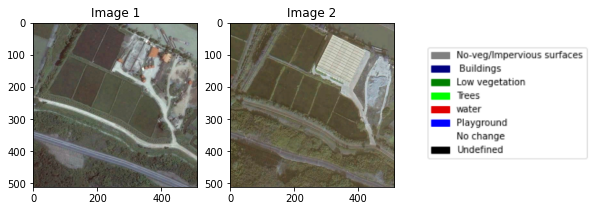

In [41]:
#RUN AND CLICK IMAGES TO VIEW HOW THE INPUT IMAGES LOOK
btn_1= widgets.Button(
    description='Image 1',
    disabled=False,
    button_style='success',
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)


def on_btn1_clicked(b):
    test_ids=['00015','00603','00935','00286','00562']
    ind=test_ids[index-1]
    img_A = cv2.imread(DATA_FOLDER1.format(ind))
    clear_output(True)       
    fig, ax = plt.subplots(1,2)
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.axis('off')
    ax[0].set_title('Image 1')
    ax[0].imshow(img_A)
    display(widgets.HBox((btn_1, btn_2)))
btn_1.on_click(on_btn1_clicked)

btn_2= widgets.Button(
    description='Image 2',
    disabled=False,
    button_style='success',
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def on_btn2_clicked(b):
    test_ids=['00015','00603','00935','00286','00562']
    ind=test_ids[index-1]
    img_A = cv2.imread(DATA_FOLDER1.format(ind))
    img_B = cv2.imread(DATA_FOLDER2.format(ind))
    img_C = cv2.imread(MAIN_FOLDER+'legend2.PNG')
    plt.rcParams['figure.figsize'] = [10, 5]
    clear_output(True) 
    fig, ax = plt.subplots(1,3) 
    ax[0].set_title('Image 1')
    ax[0].imshow(img_A)  
    ax[1].set_title('Image 2')
    ax[1].imshow(img_B)
    ax[2].set_axis_off()
    ax[2].imshow(img_C)
    display(widgets.HBox((btn_1, btn_2)))
btn_2.on_click(on_btn2_clicked)

display(widgets.HBox((btn_1, btn_2)))

In [42]:
path=get_image(index-1)
path2=path[:-14]+"1"+path[-13:]

Button(button_style='success', description='Detect changes', icon='check', style=ButtonStyle(), tooltip='Click…

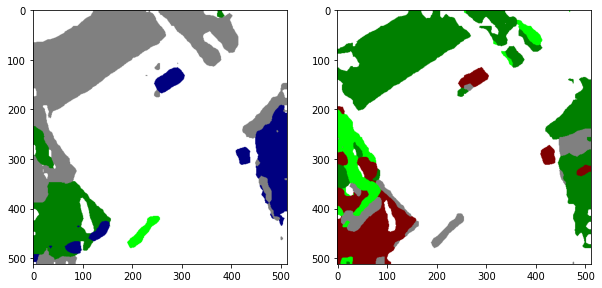

In [46]:
#SEGMENTATION OUTPUT FOR CHANGE DETECTION
button= widgets.Button(
    description='Detect changes',
    disabled=False,
    button_style='success',
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
display(button)
def on_button_clicked(b):
  img_E=cv2.imread(path)
  fig2, ax2 = plt.subplots(1,2)
  img_F=plt.imread(path2)
  ax2[0].imshow(img_E)
  ax2[1].imshow(img_F)
button.on_click(on_button_clicked)